# Clustering of trajectories

In [5]:
import shnitsel as sh
import shnitsel.xarray
import matplotlib.pyplot as plt
import xarray as xr

from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

In [6]:
homologs = sh.open_frames('/tmp/homologs.nc')
homologs

<xarray.Dataset> Size: 340MB
Dimensions:    (state: 3, frame: 53332, direction: 3, statecomb: 3, atom: 6,
                trajid_: 255)
Coordinates:
  * state      (state) int64 24B 1 2 3
  * atom       (atom) int64 48B 0 1 2 3 4 5
  * direction  (direction) <U1 12B 'x' 'y' 'z'
  * trajid_    (trajid_) int32 1kB 2 3 6 13 17 19 20 ... 938 944 947 954 961 969
    atNames    (frame, atom) <U1 1MB ...
  * statecomb  (statecomb) object 24B MultiIndex
  * from       (statecomb) int64 24B 1 1 2
  * to         (statecomb) int64 24B 2 3 3
  * frame      (frame) object 427kB MultiIndex
  * cmpnd      (frame) <U3 640kB 'I01' 'I01' 'I01' 'I01' ... 'A03' 'A03' 'A03'
  * trajid     (frame) int64 427kB 2 2 2 2 2 2 2 ... 316 316 316 316 316 316 316
  * time       (frame) float64 427kB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
Data variables: (12/13)
    energy     (state, frame) float64 1MB ...
    dip_perm   (state, direction, frame) float64 4MB ...
    dip_trans  (statecomb, direction, frame) float64 4MB ...
    sdiag      (frame) int64 427kB ...
    astate     (frame) int64 427kB ...
    forces     (state, atom, direction, frame) float64 23MB ...
    ...         ...
    nacs       (statecomb, atom, direction, frame) float64 23MB ...
    atXYZ      (atom, direction, frame) float64 8MB ...
    max_ts     (trajid_, frame) float64 109MB ...
    completed  (trajid_, frame) float32 54MB ...
    nsteps     (trajid_, frame) float64 109MB ...
    e_kin      (frame) float64 427kB ...
Attributes:
    delta_t:  0.5

In [8]:
homologs = sh.open_frames('/tmp/homologs.nc')
pwdists = homologs.atXYZ.sh.subtract_combinations('atom').sh.norm().transpose('frame', 'atomcomb')
_, pca_obj = pwdists.sel(cmpnd='A03').sh.pca('atomcomb', return_pca_object=True)
pca = pca_obj.transform(pwdists)
pca = homologs.atXYZ.sh.pairwise_dists_pca().copy(data=pca)
pca['dih'] = homologs.atXYZ.sh.dihedral(3, 1, 0, 2, deg=True)
pca['is_hop'] = homologs.astate.sh.sudi() != 0
pca['astate'] = homologs.astate

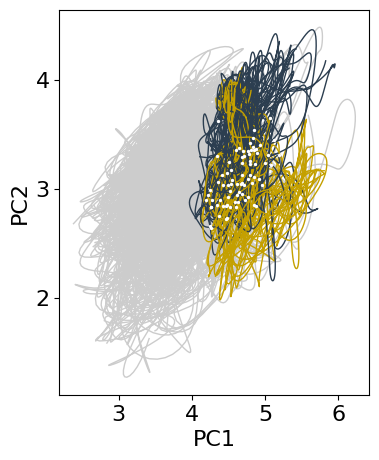

In [9]:
plt.rc('font', size=16)
plt.rc('lines', linewidth=1)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(4, 5)
for (cmpnd, trajid), traj in pca.sh.mgroupby(['cmpnd', 'trajid']):
    if cmpnd == 'A03':
        if traj['dih'].isel(frame=-1) < 80:
            c = '#2c3e50'
            zorder = 10
        elif traj['dih'].isel(frame=-1) > 100:
            c = '#C4A000'
            zorder = 10
        else:
            c = '#ccc'
            zorder = 9
        ax.plot(traj[:,0], traj[:,1], c=c, zorder=zorder)
        hops = traj[traj['is_hop']]
        ax.scatter(hops[:, 0], hops[:, 1], zorder=11, c='white', s=2)

    else:
        ax.plot(traj[:,0], traj[:,1], c='#ccc')

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_xticks([3, 4, 5, 6])
ax.set_yticks([2, 3, 4])
fig.savefig('/nc/reports/2025-06-30_4-step_figure/3.pdf')
fig.savefig('/nc/reports/2025-06-30_4-step_figure/3.png')

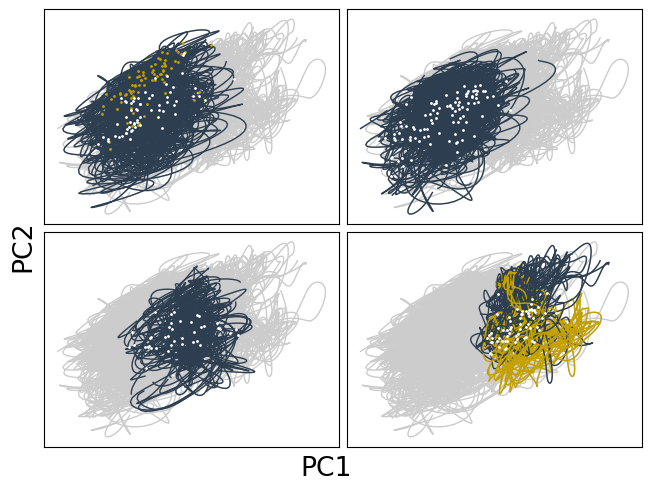

In [10]:
fig, axs = plt.subplot_mosaic([['I01', 'A01'],['A02', 'A03']], layout='constrained')

for name, ax in axs.items():
    # ax.set_title(name)

    # ax.axis('on')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # ax.tick_params(axis="x", bottom=False, labelbottom=False)

    for (cmpnd, trajid), traj in pca.sh.mgroupby(['cmpnd', 'trajid']):
        ax.plot(traj[:,0], traj[:,1], c='#ccc')# , alpha=0.5)

for (cmpnd, trajid), traj in pca.sh.mgroupby(['cmpnd', 'trajid']):
    if cmpnd != 'A03':
        c = '#2c3e50' #'#7E5273'
    elif traj['dih'].isel(frame=-1) < 80:
        c = '#2c3e50'
    elif traj['dih'].isel(frame=-1) >= 100:
        c = '#C4A000'
    else:
        continue
        
    axs[cmpnd].plot(traj[:,0], traj[:,1], c=c, zorder=9)#, alpha=0.5)
    hops = traj[traj['is_hop']]
    if hops.sizes['frame'] == 0:
        continue
    for astate, hop_group in hops.groupby('astate'):
        if cmpnd == 'I01':
            match astate:
                case 2: c = '#C4A000'
                case 1: c = 'white'
        else:
            c = 'white'
        if cmpnd == 'A01' and astate == 2:
            continue
        axs[cmpnd].scatter(hop_group[:, 0], hop_group[:, 1], zorder=10, c=c, s=1)
    
fig.supxlabel('PC1')
fig.supylabel('PC2')

fig.savefig('/nc/reports/2025-06-30_4-step_figure/pca_homologs.pdf')
fig.savefig('/nc/reports/2025-06-30_4-step_figure/pca_homologs.png')